In [1]:
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
import torch
from PIL import Image
import requests
from torch.nn.parallel import DataParallel
import matplotlib.pyplot as plt
import openai
import ast
import pickle
import io

# Ensuring the device is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the model and processor
model = InstructBlipForConditionalGeneration.from_pretrained(
    "Salesforce/instructblip-vicuna-13b", torch_dtype=torch.float16
)
processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-13b")

# Move model to GPU and use DataParallel
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)

# Move model to the appropriate device
model = model.to(device)

/users/thua5/anaconda/lavis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 6/6 [01:10<00:00, 11.82s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Using 2 GPUs!


In [2]:
# set the openai api key here
# API_KEY = 

In [3]:
def extract_list(astr):
    left_i = astr.index("[")
    right_i = astr.index("]")
    return astr[left_i:right_i+1]

# caption_to_info_list takes in a caption string and 
# returns a list of information extracted from the caption
# This is used to enhance the alt-text generation prompt
def caption_to_info_list(caption:str) -> list:
    
    client = openai.OpenAI(api_key = API_KEY)
    
    response = client.chat.completions.create(
        model="gpt-4-1106-preview",
        max_tokens=100,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": f"""Extract the type of image, the type of the celestial object, and the name of the celestial object, given the following caption. Return the information as a python list of strings.
        "{caption}"
        Python list of strings: """},
          ]
    )

    response_text = response.choices[0].message.content

    response_text = response_text.strip()

    info_list = []

    try:
        info_list = ast.literal_eval(extract_list(response_text))
    except:
        print("Error: response is not a valid python list of strings.")
        print("Response:")
        print(response_text)
    
    return info_list

In [4]:
def generate_description(model, processor, im_ref:str, user_prompt:str=None, local=False, max_length=1024, sample=False):
    if local:
        try: 
            image = Image.open(im_ref).convert("RGB")
        except:
            image = Image.open(io.BytesIO(im_ref)).convert("RGB")
    else:
        image = Image.open(requests.get(im_ref, stream=True).raw).convert("RGB")

    prompt = "Describe the image to someone who cannot see it. Description: "

    if user_prompt != None:
        prompt = user_prompt
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)

    if isinstance(model, DataParallel):
        outputs = model.module.generate(
            **inputs,
            do_sample=sample,
            num_beams=5,
            max_length=max_length,
            min_length=150,
            repetition_penalty=1.7,
            length_penalty=1.0,
            temperature=1,
        )
    else:
        outputs = model.generate(
            **inputs,
            do_sample=sample,
            num_beams=5,
            max_length=max_length,
            min_length=150,
            repetition_penalty=1.7,
            length_penalty=1.0,
            temperature=1,
        )

    generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
    generated_text = generated_text.strip("\u200b").strip()
    return generated_text

In [5]:
def visualize_result_machine_only(image_link, produced_cap, tosave=False, local=False):
    if local:
        try: 
            image = Image.open(image_link).convert("RGB")
        except:
            image = Image.open(io.BytesIO(image_link)).convert("RGB")
    else:
        image = Image.open(requests.get(image_link, stream=True).raw).convert("RGB")
    figure, axs = plt.subplots(1,2, figsize=(10,5), dpi=200)
    axs[0].title.set_text("Reference Image")
    axs[0].imshow(image)
    
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    
    axs[1].title.set_text("Corresponding Alt-texts")
    axs[1].text(0, 0.9, f"Machine Alt-text: \n\n{produced_cap}", wrap=True, ha='left', va='top')
    
    for spine in axs[1].spines.values():
        spine.set_visible(False)
    
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    figure.subplots_adjust(right=0.8)
    figure.tight_layout()
     
    if tosave:
        plt.savefig(f"{'_'.join(produced_cap[:30].split())}_alt_text.png")
    
    plt.show()

def imshow(im_url, local=False):
    if local:
        try: 
            image = Image.open(im_url).convert("RGB")
        except:
            image = Image.open(io.BytesIO(im_url)).convert("RGB")
    else:
        image = Image.open(requests.get(im_url, stream=True).raw).convert("RGB")
    plt.imshow(image)
    plt.show()

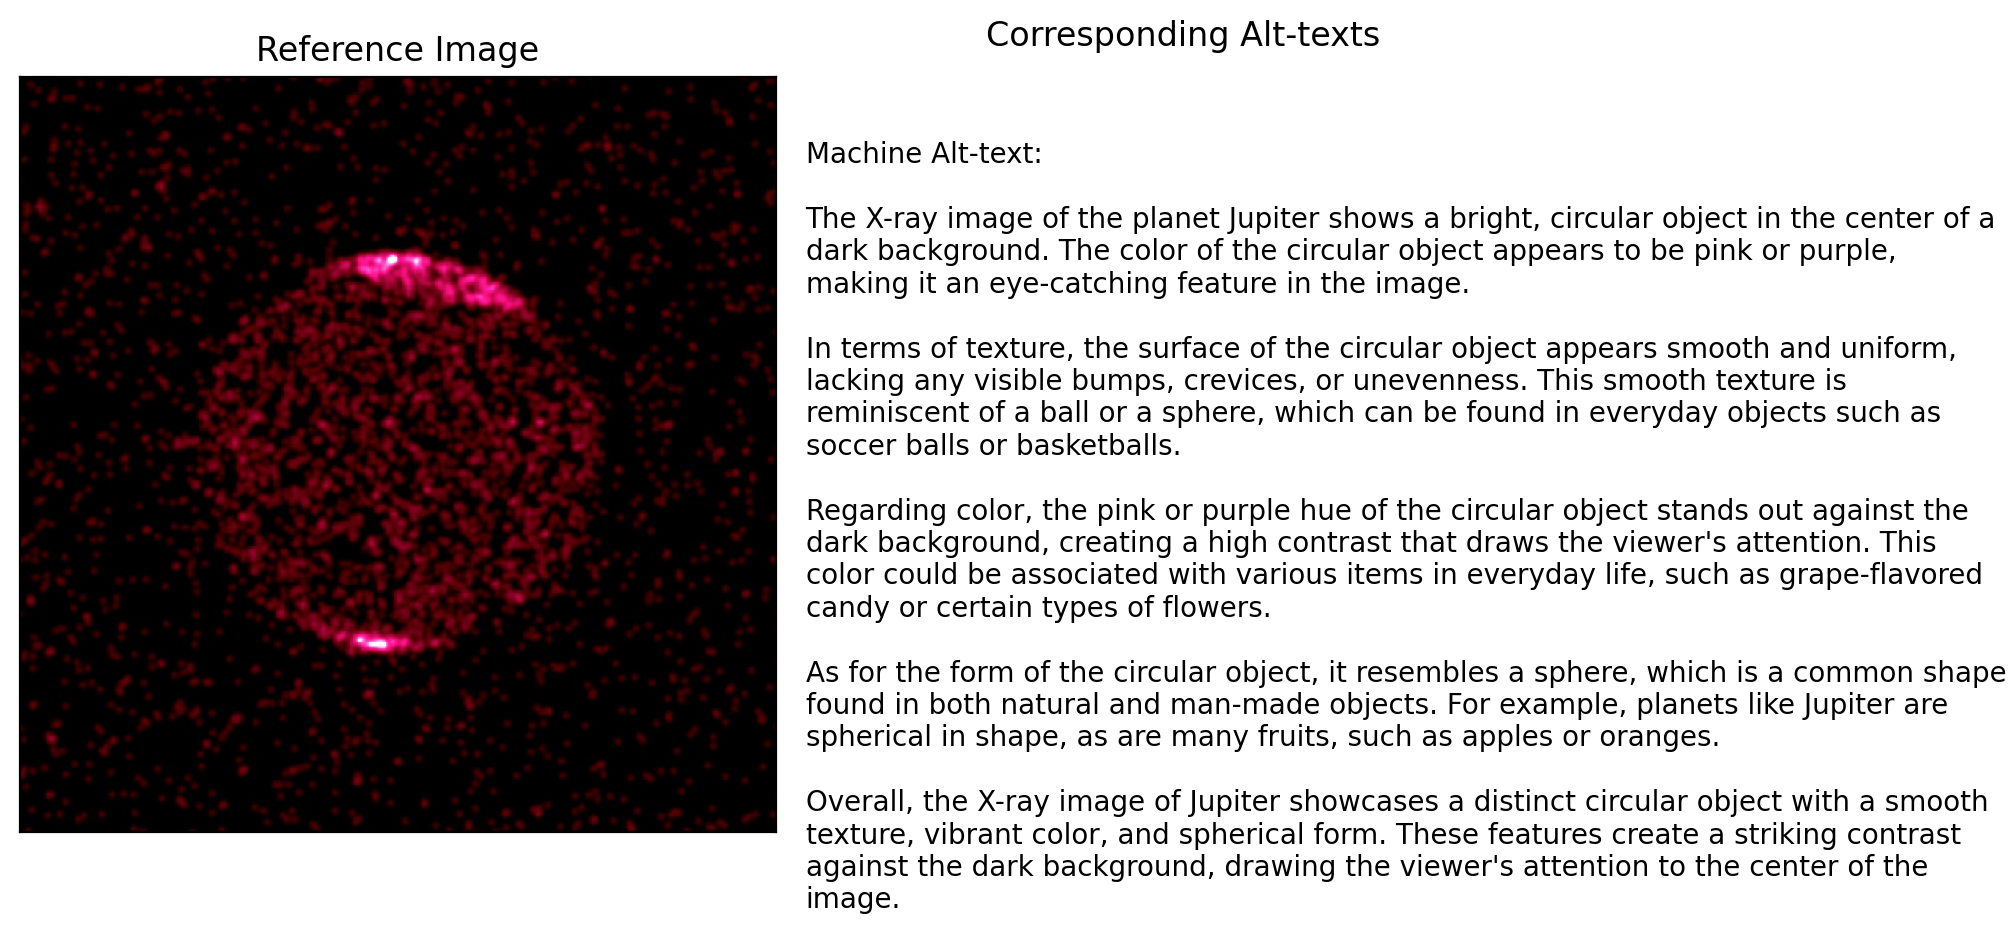

In [6]:
# an example of how to use the model, 
# given the information list is already extracted, and we are using an image online.

info_list = ['X-ray image', 'planet', 'Jupiter']

pmpt = "Generate a comprehensive visual description of the {} image of the {} {}. Focus on identifying and describing the distinct visual components within the image. Describe the textures, colors, and forms in the image, and relate them to common everyday objects or experiences to aid in mental visualization for someone who cannot see. Identify any prominent features, noting their brightness, contrast, and patterns, and explain how these might compare to familiar items or sensations in everyday life. Detail how these features interact within the space of the image, their scale in relation to one another, and their positions. The description should provide a clear and tangible picture of the image using relatable comparisons, without relying on any assumed background knowledge of astronomy. Description: ".format(*info_list)
imlink = "https://chandra.harvard.edu/photo/2002/0001/0001_xray.jpg"

produced_text = generate_description(model, processor, imlink, user_prompt=pmpt, sample=True)
visualize_result_machine_only(imlink, produced_text, tosave=False)

In [11]:
# We define the wrapper function for generating alt texts
# data is a dictionary that contains data['image'], which is a byte stream encoding an image,
# data['info'] is an string list that contains three strings: 1) the type of image, 2) the type of celestial object and 3) the name of the celestial obejct

def gen_alt_text(data):
    
    image, info_list = data['image'], data['info']

    pmpt = "Generate a comprehensive visual description of the {} image of the {} {}. Focus on identifying and describing the distinct visual components within the image. Describe the textures, colors, and forms in the image, and relate them to common everyday objects or experiences to aid in mental visualization for someone who cannot see. Identify any prominent features, noting their brightness, contrast, and patterns, and explain how these might compare to familiar items or sensations in everyday life. Detail how these features interact within the space of the image, their scale in relation to one another, and their positions. The description should provide a clear and tangible picture of the image using relatable comparisons, without relying on any assumed background knowledge of astronomy. Description: ".format(*info_list)

    produced_text = generate_description(model, processor, image, user_prompt=pmpt, sample=True, local=True)
    
    return produced_text

In [ ]:
data_sample = None
produced_text = gen_alt_text(data_sample)
visualize_result_machine_only(data_sample['image'], produced_text, tosave=False, local=True)